In [ ]:
!pip list | grep "torch"

torch                         1.9.0+cu102
torchsummary                  1.5.1
torchtext                     0.10.0
torchvision                   0.10.0+cu102


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mugan1","key":"1e7737f2708c99e5cec5976bb162f6fb"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c korean-hate-speech-detection

  0% 0.00/48.4k [00:00<?, ?B/s]
100% 48.4k/48.4k [00:00<00:00, 44.1MB/s]
  0% 0.00/43.1k [00:00<?, ?B/s]
100% 43.1k/43.1k [00:00<00:00, 44.0MB/s]
 80% 73.0M/91.0M [00:03<00:01, 11.5MB/s]
100% 91.0M/91.0M [00:03<00:00, 25.6MB/s]
  0% 0.00/2.11M [00:00<?, ?B/s]
100% 2.11M/2.11M [00:00<00:00, 69.1MB/s]
  0% 0.00/725k [00:00<?, ?B/s]
100% 725k/725k [00:00<00:00, 102MB/s]
  0% 0.00/93.9k [00:00<?, ?B/s]
100% 93.9k/93.9k [00:00<00:00, 85.2MB/s]
  0% 0.00/804k [00:00<?, ?B/s]
100% 804k/804k [00:00<00:00, 52.7MB/s]
  0% 0.00/89.0k [00:00<?, ?B/s]
100% 89.0k/89.0k [00:00<00:00, 91.2MB/s]


In [ ]:
!pip install transformers==4.4.1
!pip install tokenizers==0.10.1
!pip install sentencepiece
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install mxnet
!pip install gluonnlp 

     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 27.9 MB/s 
     |████████████████████████████████| 895 kB 71.9 MB/s 
     |████████████████████████████████| 3.2 MB 4.2 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
     |████████████████████████████████| 1.2 MB 4.1 MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-h3fbfk4p
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-h3fbfk4p
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12771 sha256=f33dce61bea976e16860c31a9551a3fab625b6186d01dd70a50a5ef6f421ecf4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ypb6d_u1/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
     |███████████████████████

In [ ]:
# import 

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import re
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast
import collections
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import torch.optim as optim
import shutil
from glob import glob
from gensim.scripts.glove2word2vec import glove2word2vec
from scipy import spatial
from gensim.models import KeyedVectors, Word2Vec, FastText
import sys
sys.path.append("..")
import os, datetime, time, re, collections
from tqdm import tqdm, trange
import json
from random import random, randrange, randint, shuffle, choice
import sentencepiece as spm
import gluonnlp as nlp
from sklearn.metrics import f1_score
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
df_train = pd.read_csv('train.hate.csv')
df_valid = pd.read_csv('dev.hate.csv')
df_test = pd.read_csv('test.hate.no_label.csv')

In [ ]:
df_train.head()

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate


In [ ]:
# 데이터 전처리 

# labeling 
df_train['label'] = df_train['label'].map({'none':0,'offensive':1, 'hate': 2})
df_valid['label'] = df_valid['label'].map({'none':0,'offensive':1, 'hate': 2})

# preprocessing 
def pre_processing(input_sentence):
    #input_sentence = input_sentence.lower() # 소문자화
    input_sentence = re.sub('<[^>]*>', repl= ' ', string = input_sentence) # "<br />" 처리
    input_sentence = re.sub('[!"$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', repl= ' ', string = input_sentence) # 특수문자 처리 ("'" 제외)
    input_sentence = re.sub('\s+', repl= ' ', string = input_sentence) # 연속된 띄어쓰기 처리
    if input_sentence:
        return input_sentence

df_train['comments'] = df_train['comments'].apply(pre_processing)
df_valid['comments'] = df_valid['comments'].apply(pre_processing)
df_test['comments'] = df_test['comments'].apply(pre_processing)

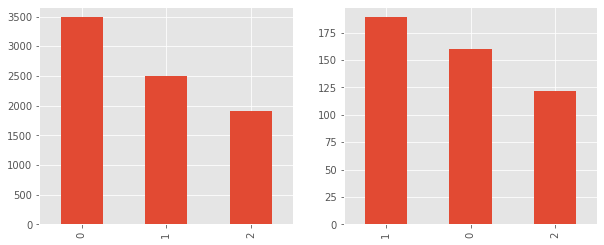

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

df_train.label.value_counts().plot(kind="bar", ax=ax[0])
df_valid.label.value_counts().plot(kind="bar", ax=ax[1]);

In [ ]:
# check special tokens
hf_model_path = './drive/My Drive/torch_project/hate_speech/tokenizer/'
fast_tokenizer = BertTokenizerFast.from_pretrained(hf_model_path+'_special')

print('check special tokens : %s'%fast_tokenizer.all_special_tokens[:20])

print('vocab size : %d' % fast_tokenizer.vocab_size)
tokenized_input_for_pytorch = fast_tokenizer("나는 오늘 아침밥을 먹었다.", return_tensors="pt")
tokenized_input_for_tensorflow = fast_tokenizer("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

print("Tokens (str)      : {}".format([fast_tokenizer.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']
vocab size : 32000
Tokens (str)      : ['[CLS]', '나', '##는', '오늘', '아침', '##밥', '##을', '먹', '##었', '##다', '.', '[SEP]']
Tokens (int)      : [2, 167, 1308, 2698, 4719, 1553, 1133, 395, 1642, 1030, 15, 3]
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



In [ ]:
# use pre_trained fast tokenizer

def vectorize_data_fast(data):
    vec_sentence = []

    for sentence in data:
      vec_sentence.append(fast_tokenizer.encode(sentence))
      
    return vec_sentence

vec_train_fast = vectorize_data_fast(df_train['comments'])
vec_val_fast = vectorize_data_fast(df_valid['comments'])

comments의 최대 길이 : 77
comments의 평균 길이 : 21.457272618620774


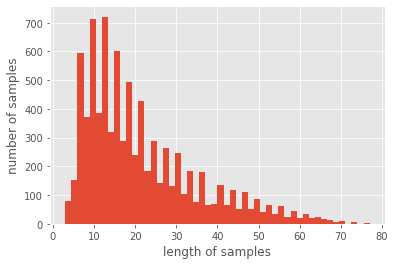

In [ ]:
total_vec_fast = vec_train_fast+vec_val_fast
print('comments의 최대 길이 :',max(len(l) for l in total_vec_fast))
print('comments의 평균 길이 :',sum(map(len, total_vec_fast))/len(total_vec_fast))
plt.hist([len(s) for s in total_vec_fast], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def add_padding_fast(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

x_train_fast = add_padding_fast(vec_train_fast, 77)
x_val_fast = add_padding_fast(vec_val_fast, 77)
y_train_fast = df_train['label'].values
y_val_fast = df_valid['label'].values

print(x_train_fast.shape)
print(x_val_fast.shape)
print(y_train_fast.shape)
print(y_val_fast.shape)

(7896, 78)
(471, 78)
(7896,)
(471,)


# Pre_training

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
data_dir='./drive/My Drive/torch_project/hate_speech'

In [ ]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
vocab_file = f"{data_dir}/tokenizer/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [ ]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_seg_type": 2,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [ ]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask


""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob


""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob


""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

In [ ]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

In [ ]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        self.pos_emb = nn.Embedding(self.config.n_enc_seq + 1, self.config.d_hidn)
        self.seg_emb = nn.Embedding(self.config.n_seg_type, self.config.d_hidn)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs, segments):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)  + self.seg_emb(segments)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

In [ ]:
""" bert """
class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)

        self.linear = nn.Linear(config.d_hidn, config.d_hidn)
        self.activation = torch.tanh
    
    def forward(self, inputs, segments):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, self_attn_probs = self.encoder(inputs, segments)
        # (bs, d_hidn)
        outputs_cls = outputs[:, 0].contiguous()
        outputs_cls = self.linear(outputs_cls)
        outputs_cls = self.activation(outputs_cls)
        # (bs, n_enc_seq, n_enc_vocab), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, outputs_cls, self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

In [ ]:
""" BERT pretrain """
class BERTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.bert = BERT(self.config)
        # classfier
        self.projection_cls = nn.Linear(self.config.d_hidn, 2, bias=False)
        # lm
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_enc_vocab, bias=False)
        self.projection_lm.weight = self.bert.encoder.enc_emb.weight
    
    def forward(self, inputs, segments):
        # (bs, n_enc_seq, d_hidn), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, outputs_cls, attn_probs = self.bert(inputs, segments)
        # (bs, 2)
        logits_cls = self.projection_cls(outputs_cls)
        # (bs, n_enc_seq, n_enc_vocab)
        logits_lm = self.projection_lm(outputs)
        # (bs, n_enc_vocab), (bs, n_enc_seq, n_enc_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return logits_cls, logits_lm, attn_probs

In [ ]:
""" 마스크 생성 """
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        for index in index_set:
            masked_token = None
            if random() < 0.8: # 80% replace with [MASK]
                masked_token = "[MASK]"
            else:
                if random() < 0.5: # 10% keep original
                    masked_token = tokens[index]
                else: # 10% random word
                    masked_token = choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

def trim_tokens(tokens_a, tokens_b, max_seq):
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

def create_pretrain_instances(docs, doc_idx, doc, n_seq, mask_prob, vocab_list):
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3
    tgt_seq = max_seq
    
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i]) # line
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                a_end = 1
                if 1 < len(current_chunk):
                    a_end = randrange(1, len(current_chunk))
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                
                tokens_b = []
                if len(current_chunk) == 1 or random() < 0.5:
                    is_next = 0
                    tokens_b_len = tgt_seq - len(tokens_a)
                    random_doc_idx = doc_idx
                    while doc_idx == random_doc_idx:
                        random_doc_idx = randrange(0, len(docs))
                    random_doc = docs[random_doc_idx]

                    random_start = randrange(0, len(random_doc))
                    for j in range(random_start, len(random_doc)):
                        tokens_b.extend(random_doc[j])
                else:
                    is_next = 1
                    for j in range(a_end, len(current_chunk)):
                        tokens_b.extend(current_chunk[j])

                trim_tokens(tokens_a, tokens_b, max_seq)
                assert 0 < len(tokens_a)
                assert 0 < len(tokens_b)

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [ ]:
""" pretrain 데이터 생성 """
def make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob):
    vocab_list = []
    for id in range(vocab.get_piece_size()):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1
    
    docs = []
    with open(in_file, "r") as f:
        doc = []
        with tqdm(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                        # 메모리 사용량을 줄이기 위해 100,000개만 처리 함
                        if 100000 < len(docs): break
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)

    for index in range(count):
        output = out_file.format(index)
        if os.path.isfile(output): continue

        with open(output, "w") as out_f:
            with tqdm(total=len(docs), desc=f"Making") as pbar:
                for i, doc in enumerate(docs):
                    instances = create_pretrain_instances(docs, i, doc, n_seq, mask_prob, vocab_list)
                    for instance in instances:
                        out_f.write(json.dumps(instance))
                        out_f.write("\n")
                    pbar.update(1)

In [ ]:
in_file = f'{data_dir}/train_text/kowiki.txt'
count = 1
n_seq = 256
mask_prob = 0.15
out_file = f"{data_dir}/train_text/kowiki_bert" + "_{}.json"

make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob)

Loading:  15%|█▌        | 574591/3724301 [00:35<03:16, 16052.04it/s]


In [ ]:
""" pretrain 데이터셋 """
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels_cls = []
        self.labels_lm = []
        self.sentences = []
        self.segments = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                instance = json.loads(line)
                self.labels_cls.append(instance["is_next"])
                sentences = [vocab.piece_to_id(p) for p in instance["tokens"]]
                self.sentences.append(sentences)
                self.segments.append(instance["segment"])
                mask_idx = np.array(instance["mask_idx"], dtype=np.int)
                mask_label = np.array([vocab.piece_to_id(p) for p in instance["mask_label"]], dtype=np.int)
                label_lm = np.full(len(sentences), dtype=np.int, fill_value=-1)
                label_lm[mask_idx] = mask_label
                self.labels_lm.append(label_lm)
    
    def __len__(self):
        assert len(self.labels_cls) == len(self.labels_lm)
        assert len(self.labels_cls) == len(self.sentences)
        assert len(self.labels_cls) == len(self.segments)
        return len(self.labels_cls)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels_cls[item]),
                torch.tensor(self.labels_lm[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor(self.segments[item]))


""" pretrain data collate_fn """
def pretrin_collate_fn(inputs):
    labels_cls, labels_lm, inputs, segments = list(zip(*inputs))

    labels_lm = torch.nn.utils.rnn.pad_sequence(labels_lm, batch_first=True, padding_value=-1)
    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels_cls, dim=0),
        labels_lm,
        inputs,
        segments
    ]
    return batch

In [ ]:
""" pretrain 데이터 로더 """
batch_size = 32
dataset = PretrainDataSet(vocab, data_dir+"/train_text/kowiki_bert_0.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

Loading ./drive/My Drive/torch_project/hate_speech/train_text/kowiki_bert_0.json: 100%|██████████| 138569/138569 [00:45<00:00, 3040.62 lines/s]


In [ ]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            labels_cls, labels_lm, inputs, segments = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(inputs, segments)
            logits_cls, logits_lm = outputs[0], outputs[1]

            loss_cls = criterion_cls(logits_cls, labels_cls)
            loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))
            loss = loss_cls + loss_lm

            loss_val = loss_lm.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [ ]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(config)
learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


In [ ]:
model = BERTPretrain(config)

save_pretrain = f"{data_dir}/bert_checkpoint/save_bert_pretrain.pth"
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):
    best_epoch, best_loss = model.bert.load(save_pretrain)
    print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
    best_epoch += 1

model.to(config.device)

criterion_lm = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
criterion_cls = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
offset = best_epoch
for step in range(n_epoch):
    epoch = step + offset
    if 0 < step:
        del train_loader
        dataset = PretrainDataSet(vocab, f"{data_dir}/train_text/kowiki_bert_{epoch % count}.json")
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

    loss = train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader)
    losses.append(loss)
    model.bert.save(epoch, loss, save_pretrain)

Train(0): 100%|██████████| 4331/4331 [10:15<00:00,  7.04it/s, Loss: 8.238 (13.443)]
Loading ./drive/My Drive/torch_project/hate_speech/train_text/kowiki_bert_0.json: 100%|██████████| 138569/138569 [00:46<00:00, 2956.55 lines/s]
Train(1): 100%|██████████| 4331/4331 [10:15<00:00,  7.03it/s, Loss: 6.837 (7.552)]
Loading ./drive/My Drive/torch_project/hate_speech/train_text/kowiki_bert_0.json: 100%|██████████| 138569/138569 [00:45<00:00, 3035.43 lines/s]
Train(2): 100%|██████████| 4331/4331 [10:15<00:00,  7.03it/s, Loss: 6.920 (7.032)]
Loading ./drive/My Drive/torch_project/hate_speech/train_text/kowiki_bert_0.json: 100%|██████████| 138569/138569 [00:45<00:00, 3047.52 lines/s]
Train(3): 100%|██████████| 4331/4331 [10:16<00:00,  7.03it/s, Loss: 6.976 (6.901)]
Loading ./drive/My Drive/torch_project/hate_speech/train_text/kowiki_bert_0.json: 100%|██████████| 138569/138569 [00:46<00:00, 2967.82 lines/s]
Train(4): 100%|██████████| 4331/4331 [10:15<00:00,  7.03it/s, Loss: 6.814 (6.846)]
Loading 

,loss
0,13.442791
1,7.552168
2,7.032405
3,6.901203
4,6.845837
5,6.813311
6,6.790976
7,6.772304
8,6.756447
9,6.741398


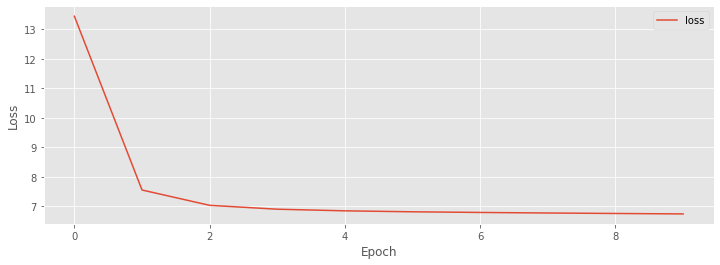

In [ ]:
# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Training 

In [ ]:
# training 

def prepare_train(vocab, df, outfile):
    
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["comments"]
            if type(document) != str:
                continue
            instance = {"doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

prepare_train(vocab, df_train, "./hate_train.json")
prepare_train(vocab, df_valid, "./hate_val.json")

In [ ]:
config = Config({
    "n_enc_vocab": vocab.get_piece_size(),
    "n_enc_seq": 256,
    "n_seg_type": 2,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [ ]:
""" hate speech classfication """
class HateSpeechClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.bert = BERT(self.config)
        # classfier
        self.projection_cls = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, inputs, segments):
        # (bs, n_enc_seq, d_hidn), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, outputs_cls, attn_probs = self.bert(inputs, segments)
        # (bs, n_output)
        logits_cls = self.projection_cls(outputs_cls)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return logits_cls, attn_probs

In [ ]:
class HateSpeechDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile, df):
        self.vocab = vocab
        self.labels = []
        self.sentences = []
        self.segments = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc="Loading Dataset", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                sentence = [vocab.piece_to_id("[CLS]")] + [vocab.piece_to_id(p) for p in data["doc"]] + [vocab.piece_to_id("[SEP]")]
                self.sentences.append(sentence)
                self.segments.append([0] * len(sentence))
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        assert len(self.labels) == len(self.segments)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor(self.segments[item]))

In [ ]:
""" hate speech data collate_fn """
def hate_speech_collate_fn(inputs):
    labels, inputs, segments = list(zip(*inputs))

    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        inputs,
        segments,
    ]
    return batch

In [ ]:
""" 데이터 로더 """
batch_size = 128
train_dataset = HateSpeechDataSet(vocab, "./hate_train.json", df_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=hate_speech_collate_fn)
val_dataset = HateSpeechDataSet(vocab, "./hate_val.json", df_valid)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=hate_speech_collate_fn)

Loading Dataset: 100%|██████████| 471/471 [00:00<00:00, 29844.35 lines/s]


In [ ]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    f1 = 0
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, inputs, segments = map(lambda v: v.to(config.device), value)

            outputs = model(inputs, segments)
            logits_cls = outputs[0]
            _, indices = logits_cls.max(1)
            f1 += f1_score(indices.cpu(), labels.cpu().numpy(), average='macro')
            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0 
            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
        f1 = f1/len(val_loader)
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0, f1

In [ ]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            labels, inputs, segments = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(inputs, segments)
            logits_cls = outputs[0]

            loss_cls = criterion_cls(logits_cls, labels)
            loss = loss_cls

            loss_val = loss_cls.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [ ]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 3
print(config)

learning_rate = 5e-5
n_epoch = 20

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 3}


In [ ]:
def train(model):
    model.to(config.device)

    criterion_cls = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_epoch, best_loss, best_score, best_f1 = 0, 0, 0,0
    losses, scores= [], []
    for epoch in range(n_epoch):
        loss = train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader)
        score, f1 = eval_epoch(config, model, val_loader)

        losses.append(loss)
        scores.append(score)

        if best_score < score:
            best_epoch, best_loss, best_score = epoch, loss, score
        if best_f1 < f1:
            best_f1 = f1
    print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}, f1={best_f1:.5f}")
    return losses, scores

In [ ]:
model = HateSpeechClassification(config)
losses_00, scores_00 = train(model)

Valid: 100%|██████████| 4/4 [00:00<00:00, 19.61it/s, Acc: 0.535]

>>>> epoch=9, loss=0.80359, socre=0.54140, f1=0.53696


In [ ]:
model = HateSpeechClassification(config)

save_pretrain = f"{data_dir}/bert_checkpoint/save_bert_pretrain.pth"
model.bert.load(save_pretrain)

losses_20, scores_20 = train(model)

Valid: 100%|██████████| 4/4 [00:00<00:00, 19.69it/s, Acc: 0.486]

>>>> epoch=7, loss=0.80283, socre=0.51592, f1=0.50949


,loss_00,socre_00,loss_20,socre_20
0,1.062912,0.409766,1.057649,0.384289
1,1.033184,0.416136,1.021817,0.509554
2,1.000732,0.454352,0.981998,0.509554
3,0.967905,0.484076,0.936590,0.467091
4,0.929868,0.467091,0.909181,0.498938
5,0.908628,0.501062,0.866728,0.498938
6,0.869780,0.518047,0.851706,0.509554
7,0.847915,0.486200,0.802830,0.515924
8,0.818771,0.515924,0.764241,0.488323
9,0.803587,0.541401,0.722127,0.503185


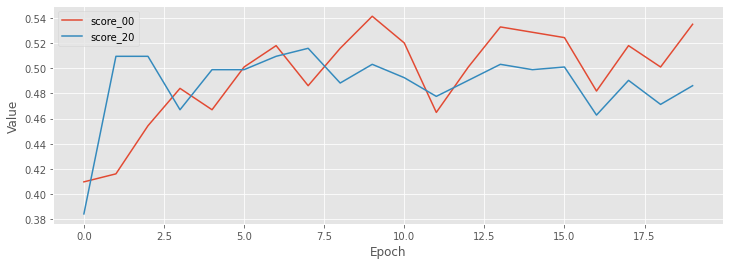

In [ ]:
# table
data = {
    "loss_00": losses_00,
    "socre_00": scores_00,
    "loss_20": losses_20,
    "socre_20": scores_20,
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(scores_00, label="score_00")
plt.plot(scores_20, label="score_20")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

# Kobert

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [ ]:
def make_data_list(data) :
  data_list = []
  for q, label in zip(data['comments'], data['label'])  :
      data = []
      data.append(q)
      data.append(str(label))

      data_list.append(data)

  return data_list

data_train = make_data_list(df_train)
data_val = make_data_list(df_valid)

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 78
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_val, 0, 1, tok, max_len, True, False)

using cached model


In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0
    f1 = 0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        _,indices = out.max(dim=1)
        val_acc += calc_accuracy(out, label)
        
        f1 += f1_score(label.cpu().detach().numpy(), indices.cpu().detach().numpy(), average='macro')
    print("epoch {} val acc {} f1 {}".format(e+1, val_acc / (batch_id+1), f1/len(val_dataloader)))

  0%|          | 0/124 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|          | 1/124 [00:00<01:20,  1.52it/s]

epoch 1 batch id 1 loss 0.024073392152786255 train acc 1.0


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 1 train acc 0.9676159274193549


100%|██████████| 8/8 [00:01<00:00,  5.77it/s]


epoch 1 val acc 0.6081861413043478 f1 0.5961695941513115


  1%|          | 1/124 [00:00<01:16,  1.61it/s]

epoch 2 batch id 1 loss 0.02182728238403797 train acc 1.0


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 2 train acc 0.9731602822580645


100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


epoch 2 val acc 0.5906080163043478 f1 0.5736577310591059


  1%|          | 1/124 [00:00<01:15,  1.63it/s]

epoch 3 batch id 1 loss 0.023509003221988678 train acc 1.0


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 3 train acc 0.9713961693548387


100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


epoch 3 val acc 0.6116677989130435 f1 0.6013810509531702


  1%|          | 1/124 [00:00<01:16,  1.61it/s]

epoch 4 batch id 1 loss 0.032418761402368546 train acc 0.984375


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 4 train acc 0.9684979838709677


100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


epoch 4 val acc 0.5706521739130435 f1 0.5518627927339854


  1%|          | 1/124 [00:00<01:17,  1.59it/s]

epoch 5 batch id 1 loss 0.056270308792591095 train acc 0.984375


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 5 train acc 0.9682459677419355


100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


epoch 5 val acc 0.6385869565217391 f1 0.6344305803653394


  1%|          | 1/124 [00:00<01:17,  1.58it/s]

epoch 6 batch id 1 loss 0.09508106112480164 train acc 0.96875


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 6 train acc 0.9555191532258065


100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


epoch 6 val acc 0.5843240489130435 f1 0.5555670320958137


  1%|          | 1/124 [00:00<01:15,  1.62it/s]

epoch 7 batch id 1 loss 0.07630214840173721 train acc 0.984375


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 7 train acc 0.9501008064516129


100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


epoch 7 val acc 0.5476392663043478 f1 0.5190078477512423


  1%|          | 1/124 [00:00<01:16,  1.61it/s]

epoch 8 batch id 1 loss 0.056098584085702896 train acc 1.0


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 8 train acc 0.9278393817204301


100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


epoch 8 val acc 0.6377377717391304 f1 0.6343592167397555


  1%|          | 1/124 [00:00<01:16,  1.61it/s]

epoch 9 batch id 1 loss 0.11565769463777542 train acc 0.953125


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 9 train acc 0.9085181451612904


100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


epoch 9 val acc 0.6396908967391304 f1 0.6375595115021709


  1%|          | 1/124 [00:00<01:17,  1.59it/s]

epoch 10 batch id 1 loss 0.32957732677459717 train acc 0.859375


100%|██████████| 124/124 [00:58<00:00,  2.12it/s]


epoch 10 train acc 0.9387600806451613


100%|██████████| 8/8 [00:01<00:00,  5.78it/s]

epoch 10 val acc 0.5897588315217391 f1 0.5706759811502796


In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        val_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                val_eval.append("Normal")
            elif np.argmax(logits) == 1:
                val_eval.append("Offensive")
            elif np.argmax(logits) == 2:
                val_eval.append("Hate")

        print(predict_sentence + " is " + val_eval[0] + " 입니다.")

using cached model


In [ ]:
for sentence, label in zip(df_valid.comments[:20], df_valid.label[:20]) :
  predict(sentence)
  print("실제 라벨 :", label)
  print()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


송중기 시대극은 믿고본다 첫회 신선하고 좋았다  is Normal 입니다.
실제 라벨 : 0

지현우 나쁜놈 is Offensive 입니다.
실제 라벨 : 1

알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라 is Offensive 입니다.
실제 라벨 : 2

설마 ㅈ 현정 작가 아니지  is Normal 입니다.
실제 라벨 : 2

이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀 하고사시죠  is Normal 입니다.
실제 라벨 : 1

일베충들 ㅂㄷ거리는것봐라 ㅉㅉ is Hate 입니다.
실제 라벨 : 2

아이즈원 힘내세요 일본 진출도 했으니 일본서 좋은 모습 보여줘도 팬들은 응원 합니다  is Normal 입니다.
실제 라벨 : 0

강부자 선생님 전미선 비보에 오열을 하셨다니 눈물이 나네요 힘내세요 is Normal 입니다.
실제 라벨 : 0

알았어 그만 is Normal 입니다.
실제 라벨 : 1

이영자씨는 진정성 있는거라면 녹화불참으로 끝내지말고 자진하차해라 시청자는 고려도 안하고 일방적 불참은 아닌듯 엠비씨도 시청율 좋아서 고민하는거 같은데 결방할게 아니고 폐지해라 is Normal 입니다.
실제 라벨 : 1

이경규가 이런거보면 세련되긴함 저 나이에 차은우 누가 알꼬 아무리 잘생겼다해도 배워야할점 많으신분 is Normal 입니다.
실제 라벨 : 0

아c발 어쩌라고 뭔기사가계속나오냐 is Normal 입니다.
실제 라벨 : 2

진짜 멋지네요  is Normal 입니다.
실제 라벨 : 0

명수 응근슬쩍 뒷치기각잡네 is Offensive 입니다.
실제 라벨 : 1

철구한테 별풍쏜놈 수준도 똑같지 뭐 ㅋㅋ is Offensive 입니다.
실제 라벨 : 1

둘이 화장실가서 싸우길 is Normal 입니다.
실제 라벨 : 1

송이매니저 거지냐 치과치료비용까지 남한테 타서 하게 솔직히 치아관리를 얼마나 안했으면 앞니가 시커멓게 될따까지 냅두냐 치과공포증은 핑계지 볼때마다 얼마